In [1]:
import os 
import calendar
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from activity_and_plot import ActivityPlotter
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt, butter, filtfilt
from scipy.fftpack import fft, fftfreq, ifft
from dataset import Dataset, ActivityType, SAMPLE_RATE, Sensor
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')



In [2]:
plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is also fine, but slower

## 1.Introduction
**Purpose of the notebook**
    
Given a dataset containing raw accelerometry data collected during outdoor walking, stair climbing, and driving for 32 healthy adults. The goal is to apply data processing and data mining methods to classify at three activities. In this notebook shows the methods applied on the data and the outcome result of the classification task.


**Key findings and outputs**

In this notebook I applied data preprocessing method and feature extraction method for preparing the data ready to be fitted into classification models, the classification algorithm I applied here are random forest and KNN, among them random forest acheived a better accuracy, 93% than KNN.
  
**Dependices used**

Used sklearn/scipy/pandas/numpy for classifiction and used matplotlib for plotting.

**References**


## 2.Load the dataset from original source 

In [3]:
# !wget -c --timeout 10 https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -O dataset.zip
# !unzip -d dataset -q dataset.zip
# !echo "Done!"

In [4]:
!ls dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/

id00b70b13.csv id3e3e50c7.csv id82b9735c.csv idb221f542.csv idf540d82b.csv
id079c763c.csv id4ea159a8.csv id86237981.csv idbae5a811.csv idf5e3678b.csv
id1165e00c.csv id5308a7d6.csv id8af5374b.csv idc735fc09.csv idfc5f05e4.csv
id1c7e64ad.csv id5993bf4a.csv id8e66893c.csv idc91a49d0.csv idff99de96.csv
id1f372081.csv id650857ca.csv id9603e9c3.csv idd80ac2b4.csv
id34e056c8.csv id687ab496.csv ida61e8ddf.csv idecc9265e.csv
id37a54bbf.csv id7c20ee7a.csv idabd0c53c.csv idf1ce9a0f.csv


## 3. Read dataset, start explortory data analysis
- Using Dataset Class initialize an object and have an overview of the whole dataframe. 
- Visualize different activity types by bar chart.
- Choosing one of the activity and plot it to see if there's any insight from it.We might find some certain frequency patterns of it.


In [5]:
dset = Dataset("./dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data")
dset._df
sample_df=pd.read_csv('dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/id00b70b13.csv')
sample_df

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,99,0.01,0.039,1.020,-0.020,-0.180,1.234,0.023,0.156,0.855,-0.582,0.887,0.449,0.074
1,99,0.02,-0.629,-0.461,0.973,-0.246,0.137,0.969,-0.707,0.559,0.449,-0.027,0.141,0.934
2,99,0.03,-0.926,-1.262,0.691,0.238,-0.328,1.219,-1.445,1.367,0.367,-0.164,0.660,1.344
3,99,0.04,-0.871,-1.496,-0.246,0.711,-0.484,0.414,-1.660,1.645,-0.543,-0.141,1.027,0.707
4,99,0.05,-0.727,-1.621,-0.559,1.031,-0.297,0.145,-1.762,1.676,-0.918,-0.121,1.230,0.438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303295,99,3032.96,0.172,-0.930,-0.320,0.000,0.000,0.000,0.160,0.020,0.977,-0.070,0.000,0.969
303296,99,3032.97,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.980,-0.070,0.000,0.969
303297,99,3032.98,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.977,-0.070,0.000,0.969
303298,99,3032.99,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.980,-0.070,0.000,0.969


There are 4*3=12 features in total, so we can maybe find some features that are highly correlated, in order to reduce the amount of features to analyse.

<Axes: >

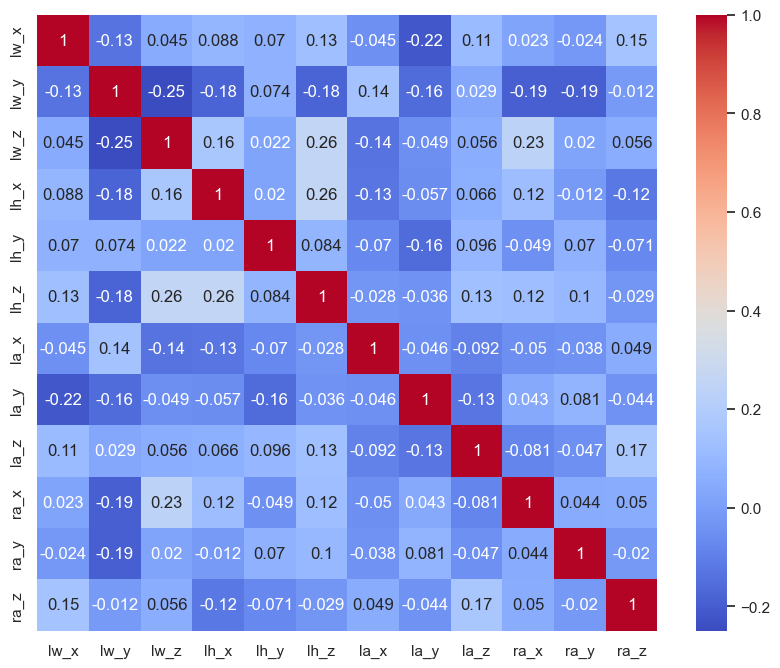

In [131]:
#Seaborn's heatmap version:
import seaborn as sns
plt.figure(figsize=(10, 8))
corr = dset._df.iloc[:,2:14].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="coolwarm")

In [7]:
# Convert correlation matrix to 1-D Series and sort
sorted_mat = corr.unstack().sort_values()
sorted_mat

lw_z  lw_y   -0.249235
lw_y  lw_z   -0.249235
la_y  lw_x   -0.218603
lw_x  la_y   -0.218603
lw_y  ra_y   -0.193335
                ...   
lh_x  lh_x    1.000000
lw_z  lw_z    1.000000
lw_y  lw_y    1.000000
ra_y  ra_y    1.000000
ra_z  ra_z    1.000000
Length: 144, dtype: float64

**bar plotting**

Using color bars to present number distribution of different activities. From the plotting, it shows that 4-DRIVING is the most common one, and 77 - clapping is the least common one.

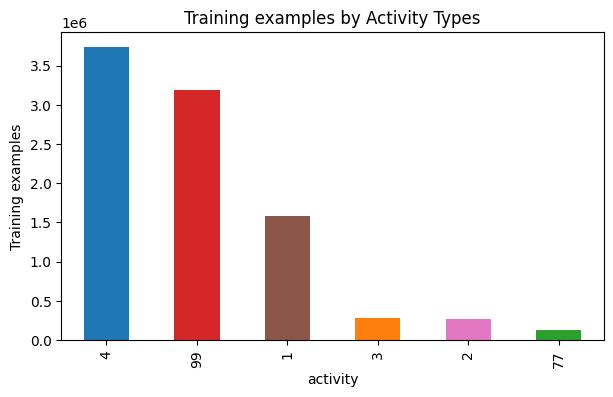

In [8]:
activity_plotter = ActivityPlotter(dset._df)
activity_plotter.make_bar_plot()

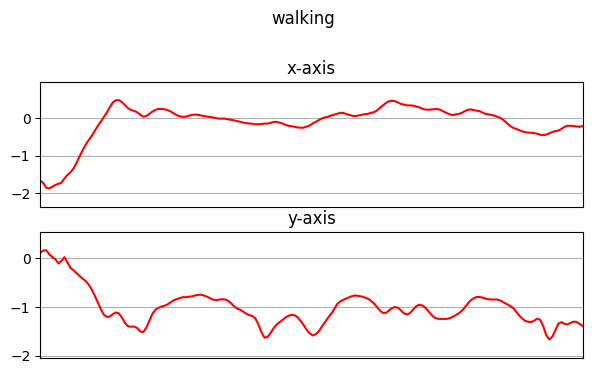

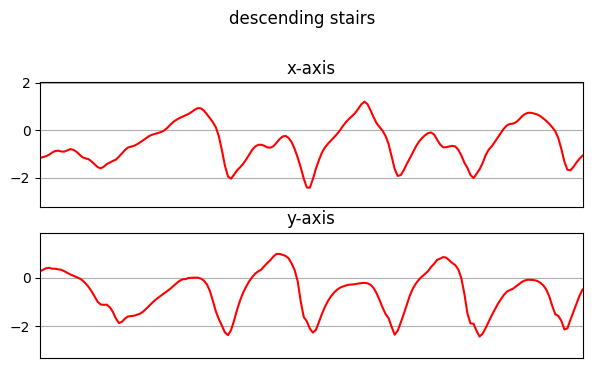

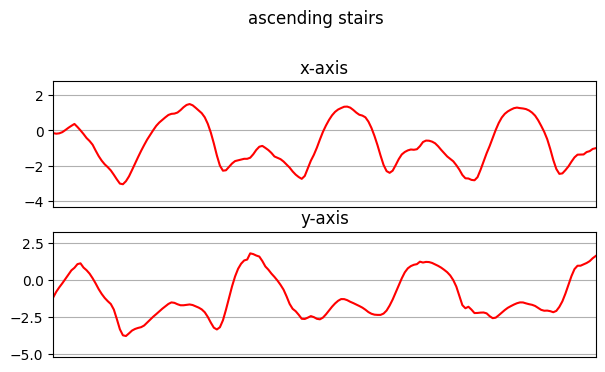

In [9]:
activity_plotter.axis_plot()

#### This is one example from all the datasets, and the activity is walking, and lw,lh,la,ra each stands for left wrist, left hip, left ankle,and right ankel.from above we can see that there is no significant difference between them, since they're from the same activity.
- Plotting for Walking

In [10]:
activity_plotter2 = ActivityPlotter(sample_df)

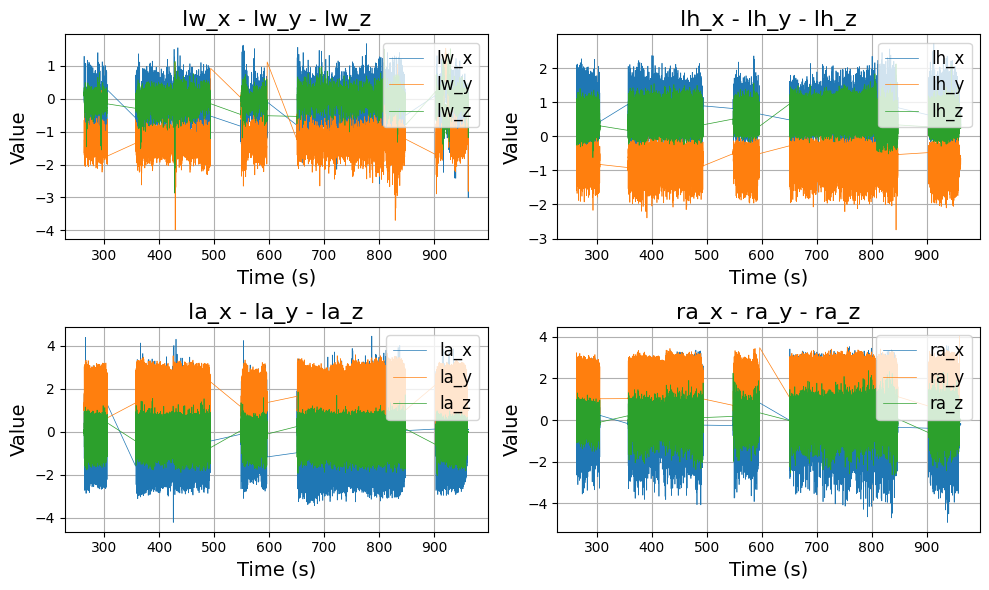

In [11]:

df = activity_plotter2.separate_activity(1)
activity_plotter2.make_x_y_z_plot(df)

- Plotting for Descending stairs

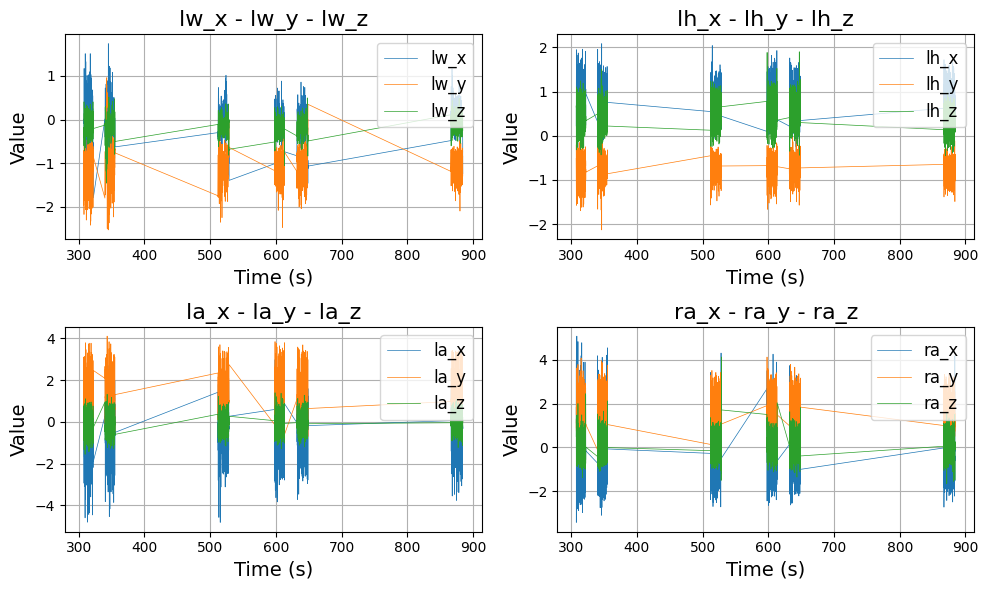

In [12]:
df = activity_plotter2.separate_activity(2)
activity_plotter2.make_x_y_z_plot(df)

- Plotting for Ascending stairs

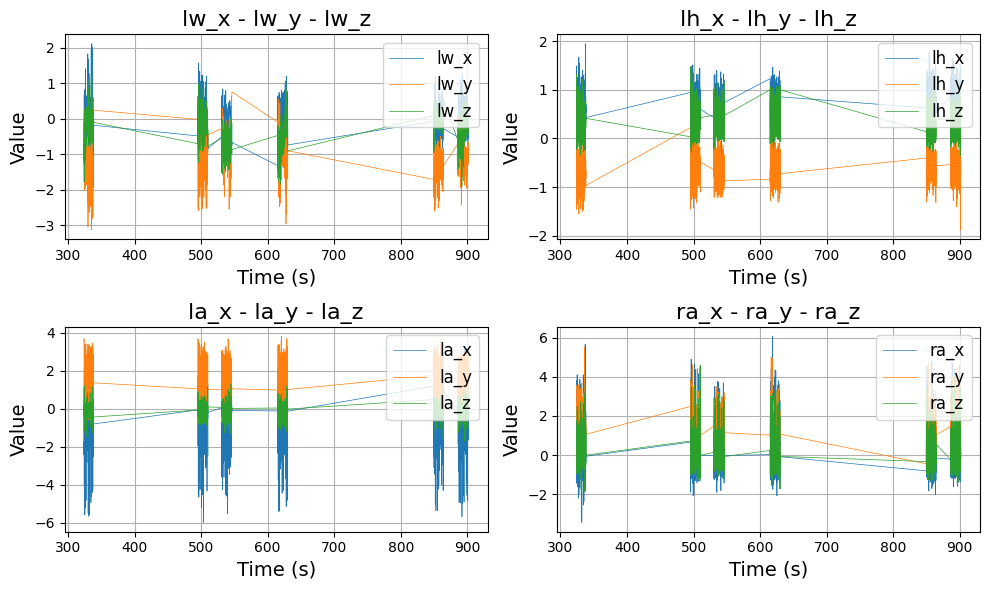

In [13]:
df = activity_plotter2.separate_activity(3)
activity_plotter2.make_x_y_z_plot(df)


## 4.Transforming by using vector magnitude to reduce feature numbers

After the initial plotting, we may have a rough idea how the plotting looks like, but there are too many vairables, it creates some trouble when doing analysis, I refer to this paper:[Differentiating Between Walking and Stair Climbing Using Raw Accelerometry Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7453603/pdf/nihms-1529153.pdf).

The suggested idea is to consolidate the multimensional, the x,y,z into a single measure, which is the vector magnitude, this can help reduce the amount of variables, also can remove the effects of sensor orientation(caused by users swinging their arms.)


The formula of vector magnitude can be described as:

$vm = \sqrt{x^2 + y^2 + z^2}$ <br>

This formula consolidates the three axes data into a single measure by taking the Euclidean distance in the 3D space.


**Data standardization** 

<p>By standardizing, I tranform the data to have a mean of zero and a std of one. This ensures all the features have the same scale, which is vital for many ml algorithms.</p>


In [14]:
from data_transform import DataTransform

In [15]:
# ### split the data frame based on the activity code
# df_1= sample_df[sample_df["activity"] == 1]
# df_2= sample_df[sample_df["activity"] == 2]
# df_3 = sample_df[sample_df["activity"] == 3]

# dset._df
df_1= dset._df[dset._df["activity"] == 1]
df_2= dset._df[dset._df["activity"] == 2]
df_3 = dset._df[dset._df["activity"] == 3]


In [16]:
df_1

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z,timestamp
35404,1,354.05,-1.664,0.105,-0.605,0.301,-0.941,-0.242,-0.070,-0.973,0.078,-0.172,1.063,0.156,0
35405,1,354.06,-1.730,0.152,-0.668,0.293,-0.945,-0.246,-0.082,-0.965,0.094,-0.172,1.070,0.152,1
35406,1,354.07,-1.855,0.156,-0.738,0.289,-0.934,-0.254,-0.082,-0.969,0.086,-0.188,1.094,0.168,2
35407,1,354.08,-1.875,0.074,-0.777,0.289,-0.926,-0.254,-0.082,-0.973,0.086,-0.207,1.102,0.188,3
35408,1,354.09,-1.828,0.016,-0.777,0.297,-0.922,-0.250,-0.098,-0.969,0.105,-0.242,1.121,0.242,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75386,1,753.87,0.066,-1.168,-0.270,0.250,-0.969,-0.055,0.070,1.000,0.160,-0.207,1.000,0.195,1576840
75387,1,753.88,0.070,-1.172,-0.285,0.254,-0.965,-0.047,0.066,1.000,0.164,-0.207,1.004,0.207,1576841
75388,1,753.89,0.070,-1.152,-0.301,0.254,-0.965,-0.043,0.063,1.000,0.164,-0.195,1.004,0.219,1576842
75389,1,753.90,0.070,-1.117,-0.313,0.250,-0.957,-0.047,0.066,1.000,0.156,-0.188,1.012,0.223,1576843


In [17]:
df_1.corr()

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z,timestamp
activity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_s,NaN,1.000000,0.031037,0.159585,0.039602,0.028009,-0.158048,0.052633,-0.006630,0.009231,-0.026178,0.023813,-0.126553,0.012064,-0.072004
lw_x,NaN,0.031037,1.000000,0.138870,0.017335,0.085487,0.039743,0.116801,0.069607,-0.205368,0.016003,0.036560,0.046458,0.024707,-0.252993
lw_y,NaN,0.159585,0.138870,1.000000,-0.210984,0.006510,0.025339,0.162466,0.029124,-0.256324,0.030993,0.019109,-0.123121,-0.007383,-0.198806
lw_z,NaN,0.039602,0.017335,-0.210984,1.000000,-0.113837,0.062903,0.063419,-0.013816,-0.011656,0.028749,-0.018977,0.087784,0.037025,-0.052321
lh_x,NaN,0.028009,0.085487,0.006510,-0.113837,1.000000,-0.289871,0.104018,0.013037,-0.030147,-0.072113,0.036615,-0.135204,-0.010307,0.025700
lh_y,NaN,-0.158048,0.039743,0.025339,0.062903,-0.289871,1.000000,0.077690,0.006231,-0.232788,0.093941,-0.033715,0.199371,-0.002502,-0.072534
lh_z,NaN,0.052633,0.116801,0.162466,0.063419,0.104018,0.077690,1.000000,0.039967,-0.153726,-0.036292,-0.022143,0.069527,-0.014665,-0.180124
la_x,NaN,-0.006630,0.069607,0.029124,-0.013816,0.013037,0.006231,0.039967,1.000000,-0.224999,-0.123939,0.034838,-0.000493,0.029445,-0.042863
la_y,NaN,0.009231,-0.205368,-0.256324,-0.011656,-0.030147,-0.232788,-0.153726,-0.224999,1.000000,-0.054064,0.018606,0.035779,0.036578,0.349252


In [18]:
data_trans1 = DataTransform(df_1)
vm1 = data_trans1.calculate_vector_magnitude() #output is dataframe
vm1.head(10)

,activity,time_s,timestamp,magnitude_lw,magnitude_lh,magnitude_la,magnitude_ra
35404,1,354.05,0,1.773681,1.017176,0.978628,1.088067
35405,1,354.06,1,1.860706,1.019505,0.973029,1.094344
35406,1,354.07,2,2.002500,1.010145,0.976259,1.122677
35407,1,354.08,3,2.030968,1.002753,0.980229,1.136924
35408,1,354.09,4,1.986346,1.000396,0.979587,1.172079
35409,1,354.10,5,1.948130,0.996189,0.981353,1.209609
35410,1,354.11,6,1.950973,0.996791,0.979765,1.289005
35411,1,354.12,7,1.945842,0.998325,0.979448,1.346029
35412,1,354.13,8,1.850549,0.996630,0.977911,1.329034
35413,1,354.14,9,1.807621,0.994043,0.975191,1.330524


### Feature correlation matrix

**Findings**:
- There are positive and negative correlation coefficents and when value is negative means that when one value is decrease, another will increase

- Among the matrix, we can notice that `lh` - left hip and `ra` - right ankle are most correlated.

<Axes: >

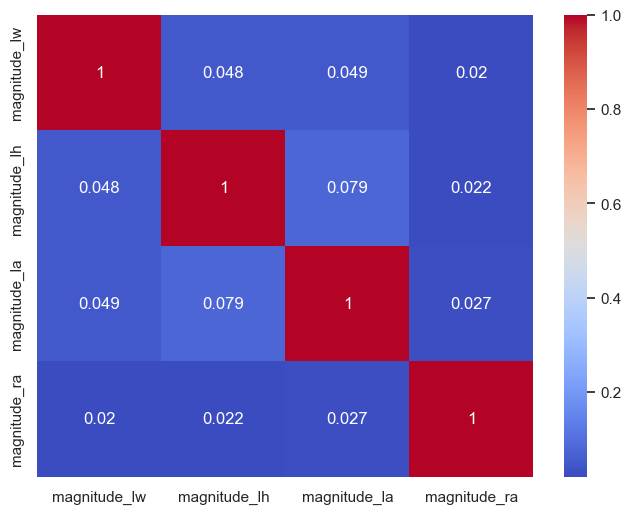

In [133]:

#Seaborn's heatmap version:
import seaborn as sns
plt.figure(figsize=(8, 6))
corr = vm1.iloc[:,3:].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="coolwarm")

## 5.Data processing
- **Apply standardization**
<p>Rescaling the attributes so they have mean=0 and standard deviation=1. </p>


- **Data segmentation**
<p>By choosing the window size of 5.12(size of window in seconds), and overlapping percentage as 50%, I break the data into smaller windows, this can help increase the amount of data, and also can help in capturing the temporal nature of activities and making the patterns more recognizble for classification.</p>
    

In [20]:
vm1

,activity,time_s,timestamp,magnitude_lw,magnitude_lh,magnitude_la,magnitude_ra
35404,1,354.05,0,1.773681,1.017176,0.978628,1.088067
35405,1,354.06,1,1.860706,1.019505,0.973029,1.094344
35406,1,354.07,2,2.002500,1.010145,0.976259,1.122677
35407,1,354.08,3,2.030968,1.002753,0.980229,1.136924
35408,1,354.09,4,1.986346,1.000396,0.979587,1.172079
...,...,...,...,...,...,...,...
75386,1,753.87,1576840,1.200617,1.002240,1.015135,1.039651
75387,1,753.88,1576841,1.208184,0.998974,1.015506,1.045808
75388,1,753.89,1576842,1.192730,0.998794,1.015315,1.045946
75389,1,753.90,1576843,1.162135,0.990231,1.014245,1.053194


In [21]:
vm_df1 = data_trans1.standardization(vm1) #output is df
rs = data_trans1.statistical_extraction("walking",vm_df1.iloc[:,3:])
rs

{'activity': 'walking',
 'mean': 1.8420952622402897e-16,
 'std': magnitude_lw    1.0
 magnitude_lh    1.0
 magnitude_la    1.0
 magnitude_ra    1.0
 dtype: float64,
 'variance': magnitude_lw    1.0
 magnitude_lh    1.0
 magnitude_la    1.0
 magnitude_ra    1.0
 dtype: float64,
 'minimum': -3.300241345089356,
 'maximum': 15.514898550618142}

In [27]:
def plot_all(df):
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")

    variables = {
    'magnitude_lw': 'lw',
    'magnitude_lh': 'lh',
    'magnitude_la': 'la',
    'magnitude_ra': 'ra'
}

    df.plot(x='time_s', y=list(variables.keys()))
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend([variables[var] for var in variables.keys()])
    plt.show()

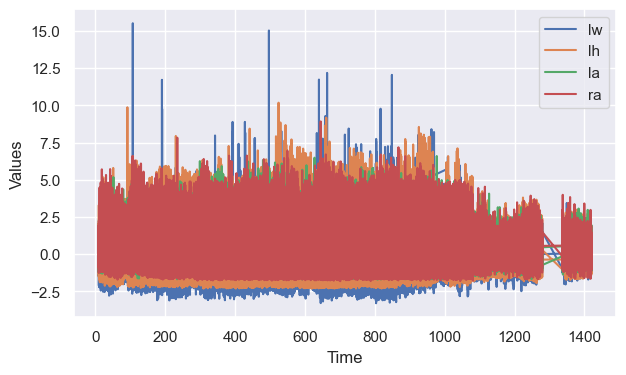

In [48]:
## plot for walking
plot_all(vm_df1)

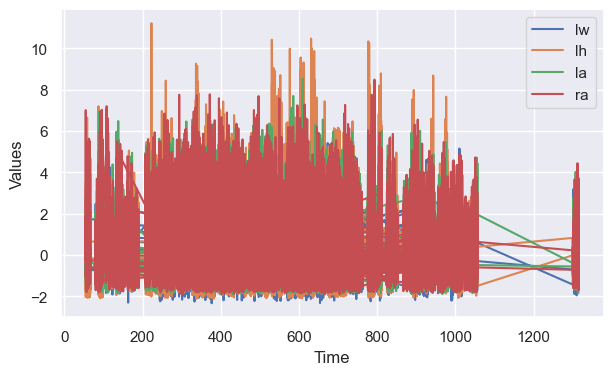

In [47]:
data_trans2 = DataTransform(df_2)
vm2 = data_trans2.calculate_vector_magnitude() #output is dataframe
vm_df2 = data_trans2.standardization(vm2) #output is df
plot_all(vm_df2)

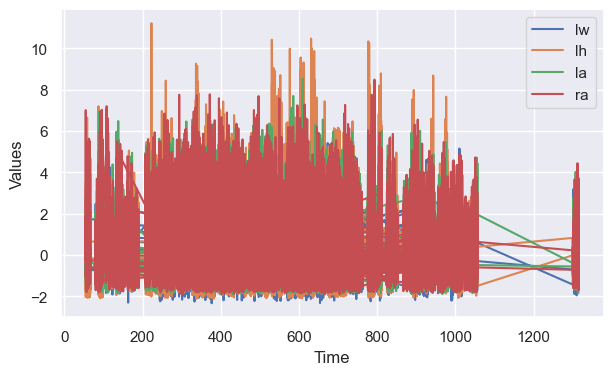

In [49]:
data_trans3 = DataTransform(df_3)
vm3 = data_trans2.calculate_vector_magnitude() #output is dataframe
vm_df3 = data_trans3.standardization(vm3) #output is df
plot_all(vm_df3)

#### Check the shape and extract certain columns and make a new dataframe

In [87]:
##run my thing and see the shape
print(vm_df1.shape) 
print(vm_df2.shape)
print(vm_df3.shape)

new_vm_df1 = vm_df1[['timestamp', 'magnitude_ra']].copy()
new_vm_df2 = vm_df2[['timestamp', 'magnitude_ra']].copy()
new_vm_df3 = vm_df3[['timestamp', 'magnitude_ra']].copy()




(1576845, 7)
(267538, 7)
(267538, 7)


In [88]:
new_vm_df1

,timestamp,magnitude_ra
35404,0,-0.630722
35405,1,-0.623746
35406,2,-0.592258
35407,3,-0.576424
35408,4,-0.537355
...,...,...
75386,1576840,-0.684529
75387,1576841,-0.677686
75388,1576842,-0.677533
75389,1576843,-0.669478


In [89]:
new_vm_df1.iloc[0:5]

,timestamp,magnitude_ra
35404,0,-0.630722
35405,1,-0.623746
35406,2,-0.592258
35407,3,-0.576424
35408,4,-0.537355


In [90]:
new_vm_df1.to_numpy().shape

(1576845, 2)

In [91]:
new_vm_df1

,timestamp,magnitude_ra
35404,0,-0.630722
35405,1,-0.623746
35406,2,-0.592258
35407,3,-0.576424
35408,4,-0.537355
...,...,...
75386,1576840,-0.684529
75387,1576841,-0.677686
75388,1576842,-0.677533
75389,1576843,-0.669478


**Data segmentation by using sliding window**

In [110]:
def sliding_window(data, window_size, overlap):
    """
    Function to generate samples using sliding window technique
    :param data: DataFrame
    :param window_size: int, size of the window
    :param overlap: int, size of overlap
    :return: list of arrays representing samples
    """

    samples = []
    start = 0
    end = window_size
    stop = len(data)
    while end <= stop:
        samples.append(data.iloc[start:end]["magnitude_ra"].values)
        start = start + window_size - overlap  #move the start to next point
        end = start + window_size

    return samples

samples_walking = sliding_window(new_vm_df1, window_size=500, overlap=0) 
samples_des_st= sliding_window(new_vm_df2, window_size=500, overlap=0) 
samples_as_st = sliding_window(new_vm_df3, window_size=500, overlap=0) 

print(len(samples_walking),len(samples_walking[0]))  #having 3153 samples and each one have 500 values
print(len(samples_des_st),len(samples_des_st[0]))
print(len(samples_as_st),len(samples_as_st[0]))


new_sample_list = samples_walking + samples_des_st + samples_as_st
print(len(new_sample_list),len(new_sample_list[0]))

new_sample = np.array(new_sample_list)
print(new_sample.shape)   #for X dataset



#generate y -label dataset
label_walking=np.empty(len(samples_walking))
label_walking.fill(1)
print(label_walking.shape)

label_des_st=np.empty(len(samples_des_st))
label_des_st.fill(2)
print(label_des_st.shape)

label_as_st=np.empty(len(samples_as_st))
label_as_st.fill(3)
print(label_as_st.shape)


new_label = np.concatenate((label_as_st, label_des_st,label_walking), axis=0)

print(new_label.shape)   #for Y dataset



3153 500
535 500
535 500
4223 500
(4223, 500)
(3153,)
(535,)
(535,)
(4223,)


In [111]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

y = new_label
X = new_sample

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

print(np.unique(y_train))


(3378, 500) (845, 500) (3378,) (845,)
[1. 2. 3.]


In [113]:
from sklearn.model_selection import GridSearchCV
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

print("\n***************************************************************")
print("*****Random Forest With Default Hyperparameters Train/Test*****")
print("***************************************************************\n")


# ************ Train/Test *********************
# Create Random Forest Classifier using default hyperparameters

default_rf_clf = RandomForestClassifier(random_state=0)
default_rf_clf.fit(X_train, y_train)
default_train_test_preds = default_rf_clf.predict(X_test)

# Create confusion matrix
print("\n*****Default Hyperparameters Test Confusion Matrix*****")
confusion_matrix = pd.crosstab(y_test, default_train_test_preds, rownames=['Actual Activity'], colnames=['Predicted Activity'])
print(confusion_matrix)

# print(confusion_matrix[1][1])
# Print accuracy
accuracy = (((confusion_matrix[1][1] + confusion_matrix[2][2] + confusion_matrix[3][3] )) / (X_test.shape[0]) * 100)
print("\nDefault Hyperparameters Test Accuracy = {0:0.4f}%".format(accuracy))



***************************************************************
*****Random Forest With Default Hyperparameters Train/Test*****
***************************************************************


*****Default Hyperparameters Test Confusion Matrix*****
Predicted Activity  1.0  2.0  3.0
Actual Activity                  
1.0                 604    1    1
2.0                  94   11    1
3.0                 112    1   20

Default Hyperparameters Test Accuracy = 75.1479%


## 6. Alternative way --- Prepare dataset for training

In [114]:
def get_magnitude(data, normalize=True):
    
    """
    Calculate vector magnitude from XYZ axes.
    inputs:
        data: A numpy array with shape (n x 3), n is number of samples and
        there are 3 axes X, Y, Z respectively.
        
        normalize: If true, perform normalization on resulting vector magnitude
        
    output:
        vector magnitude with shape: (n x 1), n is number if samples
    """
    data = np.sum(data ** 2, axis=1)
    if normalize:
        data = (data - data.mean()) / data.std()
    return data

def low_pass(x, cutoff):
    """
    Pass input signal x through a lowpass filter with a certain cutoff frequency.
    All frequency components higher than cutoff frequency will be damped to zero.
    """
    p = fft(x)
    f = fftfreq(x.shape[0], SAMPLE_RATE)
    p[f >= cutoff] = 0
    p[f < 0] = 0
    y = ifft(p)
    y = np.real(y)
    y = y / y.std()
    return y
    

raw_feats = []
gt = []
for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.RIGHT_ANKLE, start=t, duration=5) # output is array -> [100,500,3] -> 100 rows, 500columns(axis) 

    #[3, 100, 500, 3]   -> raw_feats = [300, 500, 3]
    # Walking
    # window 0 to 4 (segment)
    #             |-> time in window (0.01, 0.02, ..., 4.99, 5)
    #                   |-> data accelerometer for a specific time (x, y, z) e.g. (-0.213213, 0.1213, 0.19349)

    # window 5 to 9

    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.WALKING.value)
    
    x = dset.get(ActivityType.DESCENDING, Sensor.RIGHT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    
    raw_feats.append(x)
   
   
    gt.append(ActivityType.DESCENDING.value)
    
    x = dset.get(ActivityType.ASCENDING, Sensor.RIGHT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    
    raw_feats.append(x)
   
    gt.append(ActivityType.ASCENDING.value)

# print(raw_feats[0:10])

raw_feats = np.array(raw_feats)
gt = np.array(gt)



print(f"Features shape: {raw_feats.shape}") #[300,500] <- 3* activity (100 rows)
#(N, 500) N rows 500 columns.  each feature has N samples. like the first 1-3 rows is made up by 1. walking - 500 samples in different times.
print(f"Ground truth shape: {gt.shape}")

Features shape: (300, 500)
Ground truth shape: (300,)


In [115]:
raw_feats #each row represent one activity - one position(hip/ankel or..) - five hundreds records in a certain time period.

array([[ 5.83564022e-01, -1.23472957e-01, -6.40200907e-01, ...,
         2.56554210e+00,  2.05712875e+00,  1.35784443e+00],
       [ 2.55922680e-01,  5.28604389e-01,  7.95379149e-01, ...,
         4.07264359e-02,  6.07211778e-04,  6.61680709e-02],
       [-7.21544994e-01, -7.63850823e-01, -8.23194331e-01, ...,
        -8.70717320e-01, -7.90253819e-01, -7.30795286e-01],
       ...,
       [ 9.73201668e-01,  1.18235418e+00,  1.18018278e+00, ...,
         1.42622906e-01,  3.08823165e-01,  6.35262755e-01],
       [ 1.22432825e+00,  1.32763211e+00,  1.41391187e+00, ...,
         7.18229266e-01,  9.27213224e-01,  1.09426807e+00],
       [-5.23566649e-02,  5.79580436e-02,  1.95801949e-01, ...,
        -3.58377381e-01, -2.49281887e-01, -1.49334095e-01]])

In [116]:
# Combine feature shape and ground truth shape together preparing for train test split
data = np.concatenate((raw_feats,gt.reshape(-1,1)), axis=1)
data.shape

(300, 501)

In [117]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

y = gt
X = raw_feats

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7. Apply random forest classifying

In [118]:
from sklearn.model_selection import GridSearchCV
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

print("\n***************************************************************")
print("*****Random Forest With Default Hyperparameters Train/Test*****")
print("***************************************************************\n")


# ************ Train/Test *********************
# Create Random Forest Classifier using default hyperparameters

default_rf_clf = RandomForestClassifier(random_state=0)
default_rf_clf.fit(X_train, y_train)
default_train_test_preds = default_rf_clf.predict(X_test)

# Create confusion matrix
print("\n*****Default Hyperparameters Test Confusion Matrix*****")
confusion_matrix = pd.crosstab(y_test, default_train_test_preds, rownames=['Actual Activity'], colnames=['Predicted Activity'])
print(confusion_matrix)

# print(confusion_matrix[1][1])
# Print accuracy
accuracy = (((confusion_matrix[1][1] + confusion_matrix[2][2] + confusion_matrix[3][3] )) / (X_test.shape[0]) * 100)
print("\nDefault Hyperparameters Test Accuracy = {0:0.4f}%".format(accuracy))



***************************************************************
*****Random Forest With Default Hyperparameters Train/Test*****
***************************************************************


*****Default Hyperparameters Test Confusion Matrix*****
Predicted Activity   1   2   3
Actual Activity               
1                   21   0   1
2                    0  17   2
3                    1   1  17

Default Hyperparameters Test Accuracy = 91.6667%


In [119]:
#0.65 for lw ,  0.81 for LEFT_ANKLE, 0.86 for ra , 0.76 for LEFT_HIP

In [120]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

In [121]:

# ************ Random Forest Classifier using grid search for hyper-parameters ******************
print("\n\n***************************************************************")
print("*****************Random Forest Grid Search*********************")
print("***************************************************************\n")

# Number of trees in random forest
# Using num=2 will significantly reduce run time (~3 min vs ~65 min)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]
# Using num=10 will significantly increase run time
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
# Using num=2 will significantly reduce run time (~3 min vs ~65 min)
max_depth = [int(x) for x in np.linspace(10, 110, num = 2)]
# Using num=10 will significantly increase run time
#max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print("The values that will be used for the grid search are:")
pprint(grid)


# Create a regressor using values from grid
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = grid, cv = 3, n_jobs = -1, verbose = 1)

# Train the classifier
best_grid = grid_search.fit(X_train, y_train)

# Make predictions
grid_preds = best_grid.predict(X_test)



***************************************************************
*****************Random Forest Grid Search*********************
***************************************************************

The values that will be used for the grid search are:
{'bootstrap': [True, False],
 'max_depth': [10, 110, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 2000]}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [122]:
print("The best hyperparameters found during the grid search are:")
print(best_grid.best_params_)

The best hyperparameters found during the grid search are:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 2000}


In [123]:


print("\n************************************************************************")
print("*****Random Forest With Hyperparameters from Grid Search Train/Test*****")
print("************************************************************************\n")
# Train the Classifier with new values from grid search
rf_clf = RandomForestClassifier(max_depth = best_grid.best_params_["max_depth"], 
	min_samples_split = best_grid.best_params_["min_samples_split"], 
	min_samples_leaf = best_grid.best_params_["min_samples_leaf"], 
	bootstrap = best_grid.best_params_["bootstrap"], 
	max_features = best_grid.best_params_["max_features"], 
	n_estimators = best_grid.best_params_["n_estimators"], n_jobs=-1, random_state=0)
rf_clf.fit(X_train, y_train)
train_test_preds = rf_clf.predict(X_test)


y_score = rf_clf.fit(X_train, y_train).predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

# Create confusion matrix
print("\n*****Grid Search Hyperparameters Test Confusion Matrix*****")
confusion_matrix = pd.crosstab(y_test, train_test_preds, rownames=['Actual Income'], colnames=['Predicted Income'])
print(confusion_matrix)

# Print accuracy
grid_search_accuracy = (((confusion_matrix[1][1] + confusion_matrix[2][2] + confusion_matrix[3][3] )) / (X_test.shape[0]) * 100)

print("\nGrid Search Hyperparameters Test Accuracy = {0:0.4f}%".format(grid_search_accuracy))



************************************************************************
*****Random Forest With Hyperparameters from Grid Search Train/Test*****
************************************************************************


*****Grid Search Hyperparameters Test Confusion Matrix*****
Predicted Income   1   2   3
Actual Income               
1                 20   0   2
2                  0  18   1
3                  0   2  17

Grid Search Hyperparameters Test Accuracy = 91.6667%


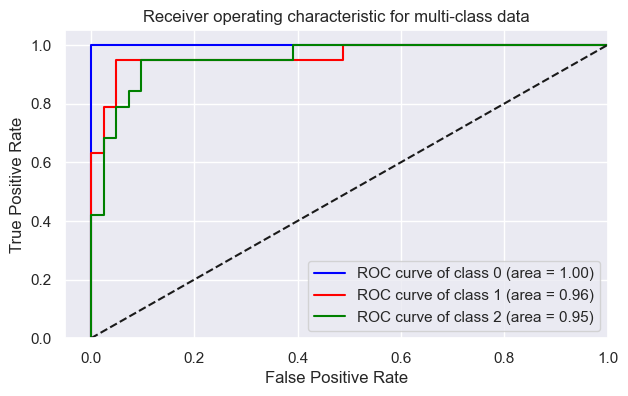

In [124]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [125]:
default_accuracy = accuracy
print("\nCompared to the random forest classifier created with default hyperparameters, the accuracy of the " +
	"classifier created with optimal hyperparameters determined by grid search is " +
	"{0:0.4f}% better".format((grid_search_accuracy - default_accuracy)))


Compared to the random forest classifier created with default hyperparameters, the accuracy of the classifier created with optimal hyperparameters determined by grid search is 0.0000% better


In [126]:
f1 = f1_score(y_test, train_test_preds, average=None)
print(f"F1 Score: {f1}")

F1 Score: [0.95238095 0.92307692 0.87179487]


## 8. Applying KNN for classification


[0.65416667 0.55       0.5875     0.5625     0.575      0.57083333
 0.55833333 0.525      0.49583333 0.52916667 0.5        0.49166667
 0.50416667 0.5125     0.50416667 0.50416667 0.5        0.4875
 0.48333333]


Text(0, 0.5, 'Cross-Validated Accuracy')

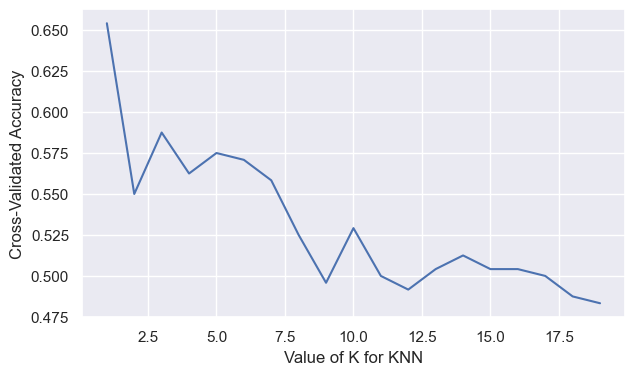

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.feature_selection import SelectKBest,chi2
from tslearn.metrics import dtw


k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier() #10 / 20
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train,y_train)

grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import datasets, neighbors
from sklearn.inspection import DecisionBoundaryDisplay


X = X_train_scaled[:,:2]
n_neighbors = 2
# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    knn = KNeighborsClassifier(n_neighbors) 
    knn.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        grid,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

NameError: name 'X_train_scaled' is not defined